In [24]:
import matplotlib.pyplot as plt
import numpy as np
# import cv2
import matplotlib.image as mpimg
import pydicom
import time
from skimage import io

In [2]:
PATH = "src\\"

In [3]:
pi = np.pi

In [4]:
def read_file(direc, file, normalization):
    file = pydicom.read_file(direc+file)
    img = file.pixel_array
    if normalization == 1:
        data = img/(np.max(img)-np.min(img))  #normalization
    else:
        data = img
    return img, data

In [5]:
def initial_curve(center, width, img_size_row, img_size_col):
    initial_map = np.ones((img_size_row,img_size_col))*-1
    initial_map[center[0]-width:center[0]+width,center[1]-width:center[1]+width] *= -1
    return initial_map

In [6]:
def force(image,s_gradient, mean1, mean2, mean3):
    edge_constrain = 1/(1+s_gradient)
    f1 = (image-mean1)**2
    f2 = (image-mean2)**2
    f3 = (image-mean3)**2
#     f4 = (image-mean4)**2
    eps = 1e-5
    N =  (1+(f1+f2+f3)*edge_constrain+3*eps)
    
    return (1/3+f1*edge_constrain+eps)/N, (1/3+f2*edge_constrain+eps)/N, (1/3+f3*edge_constrain+eps)/N#, (1/4+f4*edge_constrain+eps)/N

In [7]:
def delta(phi, eps):
    return 1/pi*(eps/(phi**2+eps**2)) #分析最大值

In [8]:
def gradient_square(img):
    return (np.gradient(img)[1])**2+(np.gradient(img)[0])**2

In [9]:
def K(phi):
    phi_x = np.gradient(phi)[1]
    phi_y = np.gradient(phi)[0]
    phi_xx = np.gradient(phi_x)[1]
    phi_xy = np.gradient(phi_x)[0]
    phi_yy = np.gradient(phi_y)[0]
    
    return (phi_xx * phi_y**2 + phi_yy * phi_x**2 - 2*phi_xy * phi_y*phi_x+1e-10)/((phi_x**2 + phi_y**2)**(3/2)+1e-10),  phi_xx+phi_yy

In [10]:
def show_contour(img, phi):
    plt.clf()
    plt.imshow(img,cmap = plt.cm.bone)
    plt.contour(phi,[0],colors='r',linewidths = 0.5) 
    plt.show()

In [11]:
def calculate_mean(img, phi_1, phi_2, gradient):
    weight = 1/(1+gradient)
    c_1 = np.sum(img[(phi_1>0)&(phi_2>0)]*(weight[(phi_1>0)&(phi_2>0)]))/np.sum(weight[(phi_1>0)&(phi_2>0)])

    c_2 = np.sum(img[(phi_1>0)&(phi_2<0)]*(weight[(phi_1>0)&(phi_2<0)]))/np.sum(weight[(phi_1>0)&(phi_2<0)])
    
#     c_3 = np.sum(img[(phi_1<0)&(phi_2>0)]*(weight[(phi_1<0)&(phi_2>0)]))/np.sum(weight[(phi_1<0)&(phi_2>0)])
    
    c_3 = np.sum(img[(phi_1<0)&(phi_2<0)]*(weight[(phi_1<0)&(phi_2<0)]))/np.sum(weight[(phi_1<0)&(phi_2<0)])
    
    return c_1, c_2, c_3

In [12]:
def evolution(data, phi_1, phi_2, gamma1, gamma2, gamma3, eta1, eta2, time_step, gs_img, c1, c2, c3, eps):
    f1, f2, f3 = force(data, gs_img, c1, c2, c3)
    
    curvature_1, _ = K(phi_1)
    curvature_2, _ = K(phi_2)
    H1 = (phi_1>0).astype(int)
    H2 = (phi_2>0).astype(int)
    
    e1 = (gamma1*f1)*H2+(gamma2*f2)*(1-H2)-gamma3*f3
    e2 = (gamma1*f1-gamma2*f2)*H1#-(gamma3*f3)*(1-H1)
    phi_1_t = phi_1 - delta(phi_1,eps)*(e1-eta1*curvature_1)
    phi_2_t = phi_2 - delta(phi_2,eps)*(e2-eta2*curvature_2)
    
    _, laplacian_1 = K(phi_1_t)
    _, laplacian_2 = K(phi_2_t)
    
    phi_1_t += 0*laplacian_1
    phi_2_t += time_step*laplacian_2
    
    c1_t, c2_t, c3_t = calculate_mean(data, phi_1_t, phi_2_t, gs_img)

    return c1_t, c2_t, c3_t, phi_1_t, phi_2_t #, functional(gamma1, gamma2, eta, f1, f2, phi_t, eps),f1, f2

In [13]:
def functional(gamma1, gamma2, eta, f1, f2, phi, eps):
     return np.sum(gamma1*f1*((phi>0).astype('int'))+gamma2*f2*((phi<0).astype('int'))+eta*delta(phi, eps)*gradient_square(phi)**0.5)
    

In [14]:
def main(img, data, center, width, lambda_set, eta_set, t_2, max_iteration,  plot = 1):
    img_size_row, img_size_col= len(img), len(img[0])
    
    phi_1 = (initial_curve(center[0], width[0], img_size_row, img_size_col))
#     phi_1[img<50] = -1
    phi_1 = phi_1/(np.max(phi_1)-np.min(phi_1))
    
    
    phi_2 = (initial_curve(center[1], width[1], img_size_row, img_size_col))
#     phi_2[img<50] = -1
    phi_2 = phi_2/(np.max(phi_2)-np.min(phi_2))
#     print(np.sum((phi_1>0)&(phi_2>0)))
#     phi_1 = np.random.rand(img_size_row, img_size_col)*-2+1
#     phi_2 = np.random.rand(img_size_row, img_size_col)*-2+1
#     phi_1 = phi_1*(img>50).astype(int)
#     phi_1 = np.sign(phi_1)
#     phi_2 = np.sign(phi_2)
    gs_img = gradient_square(data)

    c1 = np.mean(data[(phi_1>0)&(phi_2>0)]) 
    c2 = np.mean(data[(phi_1>0)&(phi_2<0)])
    c3 = np.mean(data[(phi_1<0)&(phi_2<0)])
#     c4 = np.mean(data[(phi_1<0)&(phi_2<0)])
    mean = []
    weight_mean = []
    print(c1, c2, c3)
    start = time.time()
#     energy_array = []
    var = []
    for t in range(0,max_iteration):
        
        c1_t, c2_t, c3_t, phi_1_t, phi_2_t = evolution(data, phi_1, phi_2, lambda_set[0], lambda_set[1], lambda_set[2], eta_set[0], eta_set[1], t_2, gs_img, c1, c2, c3, 0.05)
        
#         energy_array.append(energy_t)
        if plot == 1:
            if   (t % 2 == 0):
                plt.imshow(img,cmap = plt.cm.bone)
                plt.contour(phi_1,[0],colors='r',linewidths = 0.8)
                plt.contour(phi_2,[0],colors='b',linewidths = 0.5)
                plt.show()
                print(t)
        
        phi_1 = phi_1_t
        phi_2 = phi_2_t
        c1 = c1_t
        c2 = c2_t
        c3 = c3_t
        mean.append([np.mean(img[(phi_1>0)&(phi_2>0)]), np.mean(img[(phi_1>0)&(phi_2<0)]), np.mean(img[(phi_1<0)&(phi_2<0)])])
        weight_mean.append([c1, c2, c3])
        var.append([np.std(img[(phi_1>0)&(phi_2>0)]), np.std(img[(phi_1>0)&(phi_2<0)]), np.std(img[(phi_1<0)&(phi_2<0)])])

    end = time.time()
    return phi_1, phi_2, end-start, mean, weight_mean, var

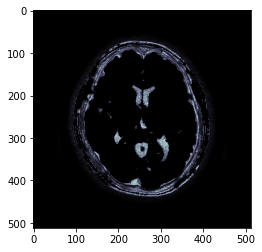

In [60]:
plt.imshow(img*((ground_truth_1<0)&(ground_truth_2<0)).astype(int),cmap = plt.cm.bone)

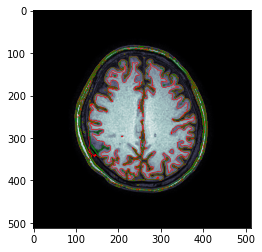

In [393]:
plt.imshow(img,cmap = plt.cm.bone)
plt.contour(ground_truth_2,[0],colors='r',linewidths = 0.5)
plt.contour(ground_truth_1,[0],colors='g',linewidths = 0.5)


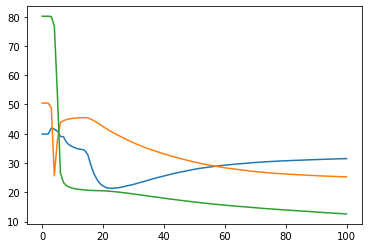

In [134]:
plt.plot(np.array(raw_var)[:,0])
plt.plot(np.array(raw_var)[:,1])
plt.plot(np.array(raw_var)[:,2])
plt.show()

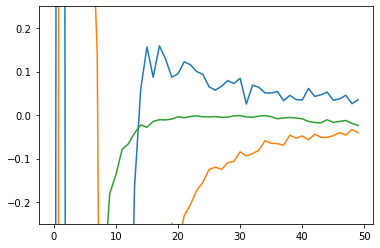

In [93]:
plt.plot(np.diff(np.array(raw_var)[:,0]))
plt.plot(np.diff(np.array(raw_var)[:,1]))
plt.plot(np.diff(np.array(raw_var)[:,2]))
plt.ylim((-0.25,0.25))
plt.show()

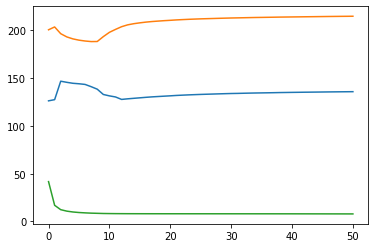

In [82]:
plt.plot(np.array(raw_mean)[:,0])
plt.plot(np.array(raw_mean)[:,1])
plt.plot(np.array(raw_mean)[:,2])
plt.show()

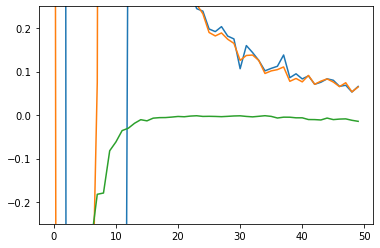

In [90]:
plt.plot(np.diff(np.array(raw_mean)[:,0]))
plt.plot(np.diff(np.array(raw_mean)[:,1]))
plt.plot(np.diff(np.array(raw_mean)[:,2]))
plt.ylim((-0.25,0.25))
plt.show()

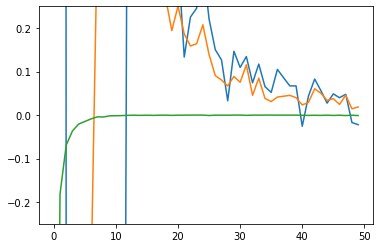

In [91]:
plt.plot(np.diff(np.array(weight_mean)[:,0]))
plt.plot(np.diff(np.array(weight_mean)[:,1]))
plt.plot(np.diff(np.array(weight_mean)[:,2]))
plt.ylim((-0.25,0.25))
plt.show()

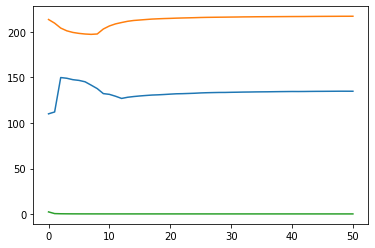

In [83]:
plt.plot(np.array(weight_mean)[:, 0])
plt.plot(np.array(weight_mean)[:, 1])
plt.plot(np.array(weight_mean)[:, 2])
plt.show()

In [45]:
from skimage import io

In [84]:
img, data = read_file(PATH, '80',1)
# img = io.imread('4.bmp')
center = [[300, 150],[320,150]]
radii = [30,5]
lambda_set = [1,1,1]
eta_set = [1e-2, 1e-2]
iteration = 61
diffusion_coeff = 0.25
plot = 0
ground_truth_1, ground_truth_2, duration, raw_mean, weight_mean, raw_var = main(img, img, center, radii, lambda_set, eta_set, diffusion_coeff,iteration,plot)
print (duration)


168.2 154.40514285714286 48.84020514883347
20.24538540840149


139 217 60


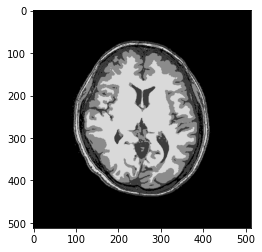

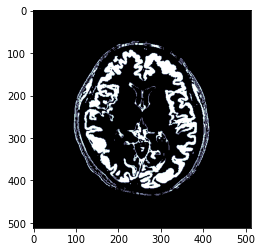

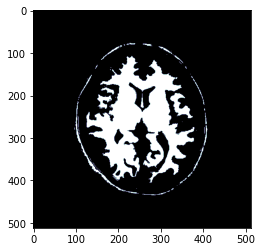

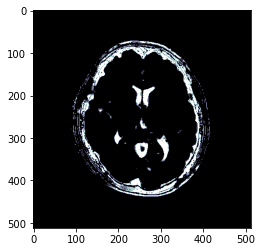

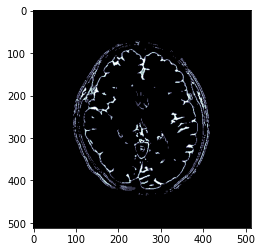

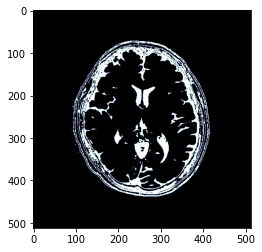

In [85]:
file_name = '80'
file = pydicom.read_file(PATH+file_name)
# plt.imshow(file.pixel_array, cmap = plt.cm.bone)
plt.imsave(PATH+file_name+'.png',file.pixel_array,cmap = plt.cm.bone)

img_result = (io.imread(PATH+file_name+'.png', as_gray=False)[:,:,0:3])
img_result = np.copy(img_result)*0

M1 = int(np.array(raw_mean)[:,0][-1])
M2 = int(np.array(raw_mean)[:,1][-1])
# M3 = int(np.array(raw_mean)[:,2][img>20][-1])
M3 = 60
print(M1, M2, M3)
img_result[(ground_truth_1>0)&(ground_truth_2>0)] = [M1, M1, M1]
img_result[(ground_truth_1>0)&(ground_truth_2<0)] = [M2, M2, M2]
img_result[(ground_truth_1<0)&(ground_truth_2<0)] = [M3, M3, M3]
img_result[(ground_truth_1<0)&(ground_truth_2>0)] = [M3, M3, M3]
img_result[img<20] = [0,0,0]
plt.imshow(img_result, cmap = plt.cm.bone)
plt.show()
plt.imsave(PATH+file_name+'_multi_region_binary.png', img_result,cmap = plt.cm.bone,  dpi = 500)

# img_result[img<20] = [0,0,0]
# fig = plt.figure()
region_1 = ((ground_truth_1>0)&(ground_truth_2>0)).astype(int)*1
#region_1[img<20] = 0
region_2 = ((ground_truth_1>0)&(ground_truth_2<0)).astype(int)*1
# region_2[img<20] = 0

# ?region_3 = img_result
# egion_3[((ground_truth_1>0)&(ground_truth_2<0))|((ground_truth_1>0)&(ground_truth_2>0))] = [0,0,0]
# region_3[(region_3 ] = [255,255,255]

region_3 =  ((ground_truth_1<0)&(ground_truth_2<0)).astype(int)*1
region_3 = region_3*(img>20).astype(int)

region_4 =  ((ground_truth_1<0)&(ground_truth_2>0)).astype(int)*1
region_4 = region_4*(img>20).astype(int)

region_5 = (((ground_truth_1<0)&(ground_truth_2>0))|((ground_truth_1<0)&(ground_truth_2<0))).astype(int)*1
region_5 = region_5*(img>20).astype(int)

plt.imshow(region_1, cmap = plt.cm.bone)
# plt.imsave(PATH+file_name+'region_1.png', region_1, cmap = plt.cm.bone,  dpi = 500)
plt.show()
plt.imshow(region_2, cmap = plt.cm.bone)
# plt.imsave(PATH+file_name+'region_2.png', region_2, cmap = plt.cm.bone, dpi = 500)
plt.show()
plt.imshow(region_3, cmap = plt.cm.bone)
plt.imsave(PATH+file_name+'region_3.png', region_3, cmap = plt.cm.bone, dpi = 500)
plt.show()
plt.imshow(region_4, cmap = plt.cm.bone)
plt.imsave(PATH+file_name+'region_4.png', region_4, cmap = plt.cm.bone, dpi = 500)
plt.show()
plt.imshow(region_5, cmap = plt.cm.bone)
plt.imsave(PATH+file_name+'region_5.png', region_5, cmap = plt.cm.bone, dpi = 500)
plt.show()

(array([804., 663.,   0., 587.,   0., 482.,   0., 479.,   0., 425.,   0.,
        409.,   0., 400.,   0., 342., 348.,   0., 320.,   0., 306.,   0.,
        274.,   0., 317.,   0., 285.,   0., 310.,   0., 317.,   0., 275.,
        310.,   0., 270.,   0., 298.,   0., 320.,   0., 304.,   0., 299.,
          0., 298.,   0., 268.,   0., 303., 287.,   0., 309.,   0., 303.,
          0., 342.,   0., 334.,   0., 312.,   0., 278.,   0., 304.,   0.,
        319., 302.,   0., 274.,   0., 289.,   0., 359.,   0., 308.,   0.,
        295.,   0., 307.,   0., 284.,   0., 305., 303.,   0., 312.,   0.,
        299.,   0., 336.,   0., 279.,   0., 340.,   0., 337.,   0., 304.,
          0., 357., 351.,   0., 336.,   0., 321.,   0., 338.,   0., 302.,
          0., 349.,   0., 353.,   0., 360., 325.,   0., 307.,   0., 321.,
          0., 305.,   0., 310.,   0., 313.,   0., 342.,   0., 323.,   0.,
        329., 293.,   0., 319.,   0., 297.,   0., 287.,   0., 300.,   0.,
        286.,   0., 303.,   0., 279., 

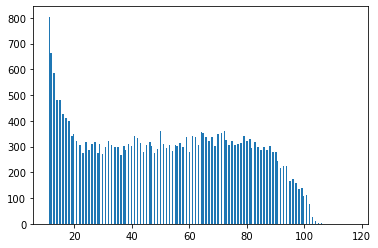

In [317]:
plt.hist((region_3.flatten()[region_3.flatten()>10]), bins=200)

In [ ]:
import math
def psnr(img1, img2):
    mse = np.mean((img1-img2).astype(int))**2
    print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = np.max(img1)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
data

In [ ]:
plt.plot((energy_array))
plt.plot()

In [ ]:
def PepperandSalt(src,percetage):
    NoiseImg = np.copy(src)
    max_pixel = np.max(src)
    NoiseNum=int(percetage*src.shape[0]*src.shape[1])
    for i in range(NoiseNum):
        randX=np.random.random_integers(0,src.shape[0]-1)
        randY=np.random.random_integers(0,src.shape[1]-1)
        if np.random.random_integers(0,1)<=0.5:
            NoiseImg[randX,randY]=0
        else:
            NoiseImg[randX,randY]=max_pixel
            
    return NoiseImg
pepper = PepperandSalt(img, 0.2)


In [ ]:
s = np.random.normal(500, 150, (512,512))
gaussian_noise = np.copy(img)+s.astype(int)

In [ ]:
plt.imshow(gaussian_noise, cmap = plt.cm.bone)

In [ ]:
d=psnr(img,gaussian_noise)
print(d)

In [ ]:
plt.imsave('Gaussian_noise_SNR_'+str(round(d,2))+'.png', gaussian_noise,cmap = plt.cm.bone, dpi = 150)

In [ ]:
test = main(gaussian_noise, gaussian_noise/(np.max(gaussian_noise)-np.min(gaussian_noise)),  [250,250], 220)

In [ ]:
show_contour(pepper, test)

In [ ]:
plt.clf()
plt.imshow(gaussian_noise*((test<0).astype(int)), cmap = plt.cm.bone)
plt.imsave( 'gaussian_noise_target.png',gaussian_noise*((test<0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()
plt.clf()
plt.imshow(img*((ground_truth<0).astype(int)), cmap = plt.cm.bone)
plt.imsave( 'IM120_back.png',img*((ground_truth>0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()

In [ ]:
def dice_score(ground_truth, result):
    a = np.sum(((ground_truth<0)&(result<0)).astype(int))
    b = np.sum(((ground_truth<0)).astype(int))
    c = np.sum(((result<0)).astype(int))
    d = np.sum(((ground_truth<0)|(result<0)).astype(int))
    return 2*a/(b+c), a/d

In [ ]:
dice_score(ground_truth, test)

In [ ]:
def SSIMnp(y_true , y_pred):
    u_true = np.mean(y_true)
    u_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    std_true = np.sqrt(var_true)
    std_pred = np.sqrt(var_pred)
    c1 = np.square(0.01*7)
    c2 = np.square(0.03*7)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom

In [ ]:
SSIMnp(img*((ground_truth<0).astype(int)), gaussian_noise*((test<0).astype(int)))

In [ ]:
from skimage import io
noisy_img = io.imread('SNR_'+str(round(d,2))+'.png', as_gray=False)[:,:,0:3]
plt.imshow(noisy_img)

In [ ]:
noisy_img[test<0]

In [ ]:
noisy_img[test>0] = [241,160,88]
noisy_img[pepper<350] = [0,0,0]
plt.imshow(noisy_img)

plt.imsave('SNR_'+str(round(d,2))+'result.png', noisy_img)

In [ ]:
plt.imsave('IM120.png', img, cmap = plt.cm.bone, dpi = 150)

In [ ]:
plt.clf()
clean_img = io.imread('IM120.png', as_gray=False)[:,:,0:3]
plt.imshow(clean_img)
clean_img[ground_truth>0] = [241,160,88]
clean_img[img<350] = [0,0,0]
plt.imshow(clean_img)

# plt.imsave('clean_with_SNR_'+str(round(d,2))+'result.png', clean_img)

In [ ]:
plt.plot(np.linspace(0,1,4),[0,0,0,0], 'r-', marker = 'x')
plt.plot(np.linspace(0,1,4),[1,1,1,1], 'b-', marker = 'o')
plt.plot(np.linspace(0,2/3,3), [0,0.5,1])
plt.ylabel('time')
plt.xlabel('grid')
plt.xticks(np.linspace(0,1,4),['$x_{i-1}$', '$x_i$', '$x_i$', '$x_i$'])
plt.show()

In [ ]:
np.linspace(0,1,4)
np.zeros(5)